In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset and set display options
loan = pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan.set_index('id',inplace=True)
pd.set_option('display.max_columns', None)


In [2]:
# As there is only 1 observation with home_ownership = ANY,
# we will drop that observation
loan = loan.drop(loan[loan['home_ownership'] == 'ANY'].index)

# Drop non-numerical and target columns from features
X = loan.drop(columns=['addr_state', 'emp_title', 'loan_status', 'issue_d', 'issue_y', 'issue_m', 'title'])

# Replace 'annual_inc' with its logarithmic version 'log_annual_inc' for normalization purposes
X = X.drop(columns=['annual_inc'])

# Remove outcome-related columns that would otherwise leak information
X = X.drop(columns=['loan_status_grouped', 'grade', 'sub_grade', 'int_rate'])

# Select the target variable for prediction
y = loan['loan_status_grouped']


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define categorical and numerical feature lists
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure alignment of train and test sets to handle any potential dummy variable mismatch
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale numerical columns to standardize the data distribution
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [4]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

xgb_model = XGBClassifier(
    n_estimators=100,        # Number of boosting rounds
    learning_rate=0.1,       # Step size shrinkage to prevent overfitting
    max_depth=6,             # Maximum depth of a tree
    subsample=0.8,           # Subsample ratio of the training data
    colsample_bytree=0.8,    # Subsample ratio of features for each tree
    gamma=0,                 # Minimum loss reduction required to make a further partition
    reg_lambda=1,            # L2 regularization term
    objective='binary:logistic' # For multiclass classification (use 'binary:logistic' for binary)
)

In [5]:
# XG-boost
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

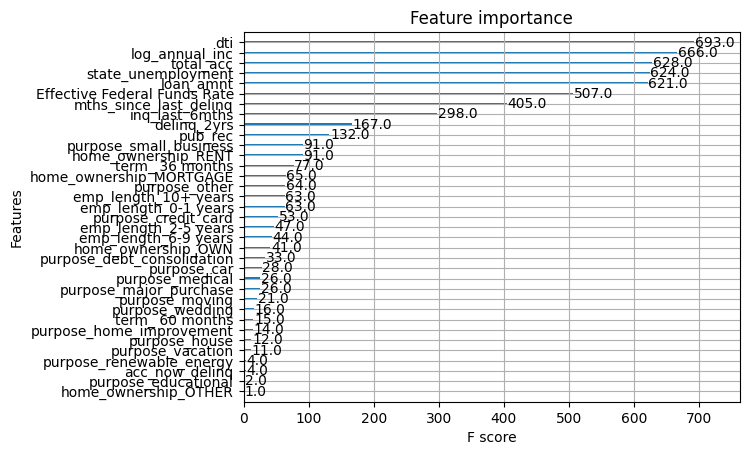

In [ ]:
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()

In [7]:
# Predict probabilities
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1] 

Accuracy: 0.62 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.61      0.72     40423
         1.0       0.32      0.68      0.44     11133

    accuracy                           0.62     51556
   macro avg       0.60      0.64      0.58     51556
weighted avg       0.75      0.62      0.66     51556



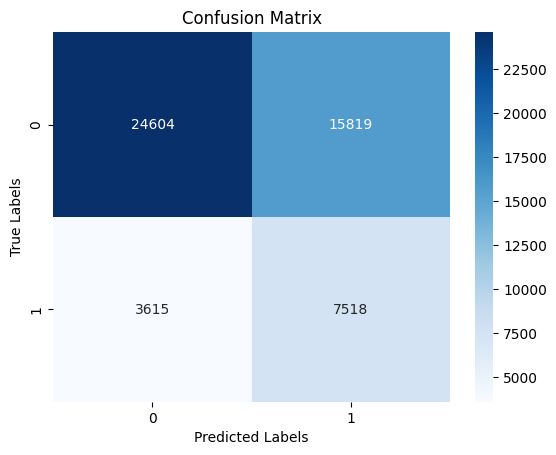

In [8]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

threshold = 0.2
y_pred = (y_pred_prob >= threshold).astype(int) 

# Generating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}', "\n")
print("Classification Report:\n", class_report)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Hyperparameter Tuning

In [9]:
# Define the range of thresholds between 0.2 and 0.3
thresholds = np.arange(0.2, 0.31, 0.01)  # Thresholds from 0.2 to 0.3 in steps of 0.01
confusion_matrices = []
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append((threshold, cm))
    
    # Calculate F1 score for the current threshold
    f1 = f1_score(y_test, y_pred)
    f1_scores.append((threshold, f1))
    
# Identify the threshold with the highest F1 score
best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])

# Print the confusion matrices and F1 scores for each threshold
for threshold, cm in confusion_matrices:
    print(f"Threshold: {threshold:.2f}\nConfusion Matrix:\n{cm}\n")

print(f"Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")

Threshold: 0.20
Confusion Matrix:
[[24604 15819]
 [ 3615  7518]]

Threshold: 0.21
Confusion Matrix:
[[25897 14526]
 [ 3972  7161]]

Threshold: 0.22
Confusion Matrix:
[[27121 13302]
 [ 4319  6814]]

Threshold: 0.23
Confusion Matrix:
[[28169 12254]
 [ 4641  6492]]

Threshold: 0.24
Confusion Matrix:
[[29250 11173]
 [ 4979  6154]]

Threshold: 0.25
Confusion Matrix:
[[30175 10248]
 [ 5300  5833]]

Threshold: 0.26
Confusion Matrix:
[[31015  9408]
 [ 5612  5521]]

Threshold: 0.27
Confusion Matrix:
[[31777  8646]
 [ 5887  5246]]

Threshold: 0.28
Confusion Matrix:
[[32469  7954]
 [ 6147  4986]]

Threshold: 0.29
Confusion Matrix:
[[33170  7253]
 [ 6416  4717]]

Threshold: 0.30
Confusion Matrix:
[[33797  6626]
 [ 6700  4433]]

Best Threshold: 0.21 with F1 Score: 0.44


Maximum TN/FN Ratio: 57.50 at Threshold: 0.04


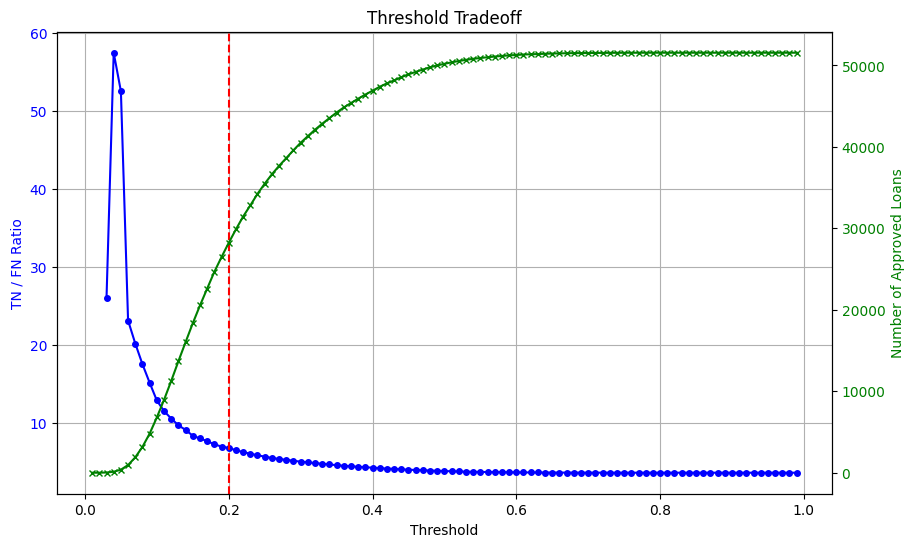

In [10]:
# Plotting True Negatives (TN) / False Negatives (FN) and number of approved loans against the threshold,

y_pred_prob = xgb_model.predict_proba(X_test)[:, 1] 

ratios = []
approved_loans = []
thresholds = np.arange(0.01, 1.00, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    TN = np.sum((y_pred == 0) & (y_test.values == 0))
    FN = np.sum((y_pred == 0) & (y_test.values == 1))
    
    if FN > 0:
        ratio = TN / FN
    else:
        ratio = np.nan 

    ratios.append(ratio)
    approved_loans.append(TN + FN)

# Filter out infinite and NaN ratios
valid_ratios = [(ratio, threshold) for ratio, threshold in zip(ratios, thresholds) if pd.notna(ratio) and ratio != np.inf]

# Find the maximum ratio and its corresponding threshold
if valid_ratios:
    max_ratio, best_threshold = max(valid_ratios, key=lambda x: x[0])

    # Print the threshold that gives the maximum ratio
    print(f'Maximum TN/FN Ratio: {max_ratio:.2f} at Threshold: {best_threshold:.2f}')
else:
    print("No valid ratios found.")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the TN/FN ratio on the primary y-axis
ax1.plot(thresholds, ratios, marker='o', markersize=4, color='b', label='TN / FN Ratio')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('TN / FN Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a secondary y-axis to plot the number of approved loans
ax2 = ax1.twinx()
ax2.plot(thresholds, approved_loans, marker='x', markersize=4, color='g', label='Number of Approved Loans')
ax2.set_ylabel('Number of Approved Loans', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set limits for the y-axes
try:
    max_ratio_limit = max(filter(lambda x: x != np.inf, ratios), default=0)
    ax1.set_ylim(0, max_ratio_limit * 1.1)

    max_approved_loans_limit = max(approved_loans, default=0)
    ax2.set_ylim(0, max_approved_loans_limit * 1.1)
except ValueError:
    pass

# Plotting a vertical line at threshold = 0.2
ax1.axvline(x=0.2, color='r', linestyle='--', label='Threshold = 0.2')

plt.title('Threshold Tradeoff')

plt.show()
